## Imports

In [ ]:
from utils.SpokenDigitDataset import SpokenDigitDataset
from utils.DatasetSplitter import DatasetSplitter
from models.ResNet import ResNet18
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import librosa.display




## Dataset

Etiqueta: 0


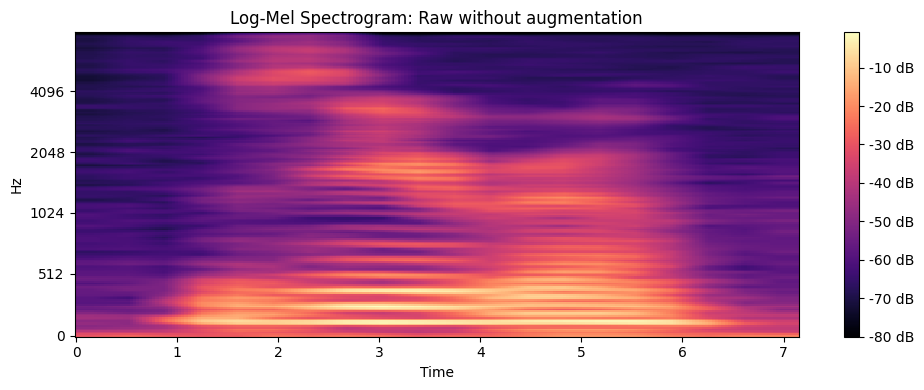

Etiqueta: 0


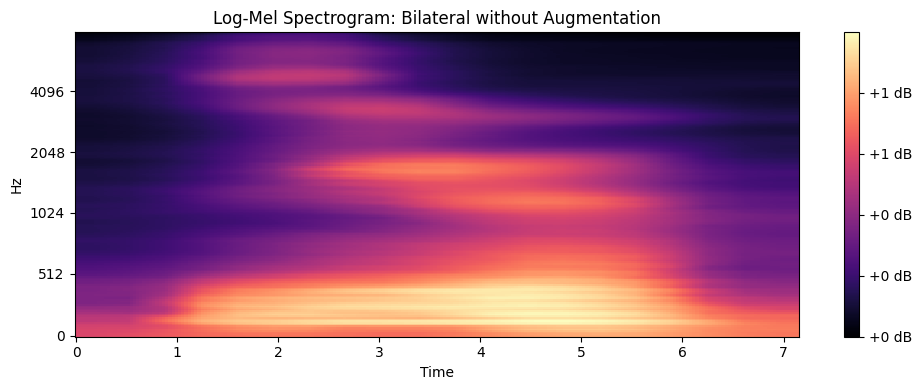

Etiqueta: 0


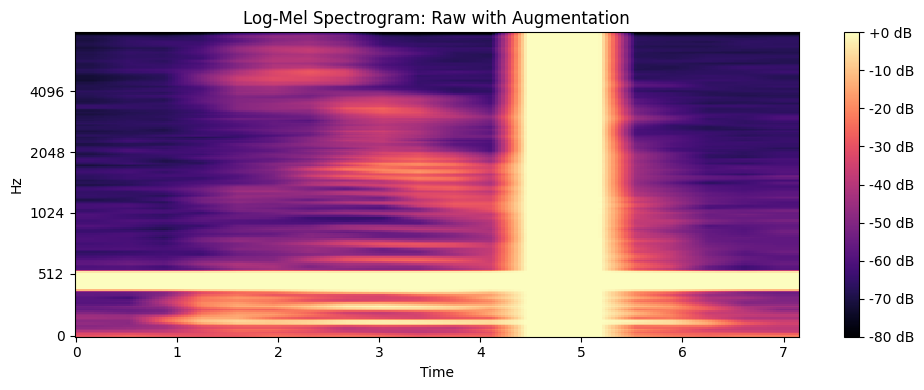

Etiqueta: 0


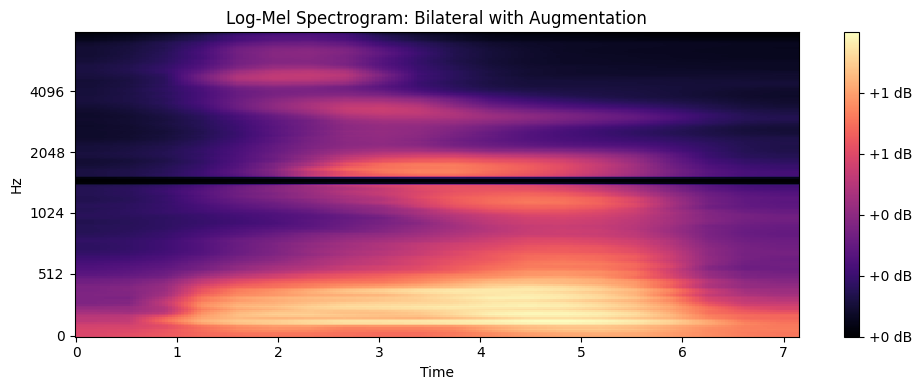

In [2]:
dataset = SpokenDigitDataset("data/audio")

# This will automatically perform the split upon creation
splitter = DatasetSplitter(
        dataset=dataset,
        split_ratios=(0.7, 0.15, 0.15) # Example: 70% train, 15% val, 15% test
)

# You can access the split datasets:
train_set = splitter.train_dataset
val_set = splitter.val_dataset
test_set = splitter.test_dataset

# print(f"\nAccessed train_set (Subset): Size {len(train_set)}")
# print(f"Accessed val_set (Subset): Size {len(val_set)}")
# print(f"Accessed test_set (Subset): Size {len(test_set)}")

# You can configure the underlying dataset for each split
# For example, enable augmentation only for the training set


# Check the configuration of the underlying dataset for a split
# print(f"\nTrain dataset underlying config after configure_splits: Bilateral={train_set.dataset.bilateral}, Augment={train_set.dataset.augment}")
# print(f"Validation dataset underlying config after configure_splits: Bilateral={val_set.dataset.bilateral}, Augment={val_set.dataset.augment}")
# print(f"Test dataset underlying config after configure_splits: Bilateral={test_set.dataset.bilateral}, Augment={test_set.dataset.augment}")


# You can access the DataLoaders:
train_loader = splitter.train_dataloader
val_loader = splitter.val_dataloader
test_loader = splitter.test_dataloader


splitter.configure_splits(bilateral=False, augment=False)
x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Raw without augmentation')
plt.tight_layout()
plt.show()

splitter.configure_splits(bilateral=True, augment=False)
x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Bilateral without Augmentation')
plt.tight_layout()
plt.show()

splitter.configure_splits(bilateral=False, augment=True)

x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Raw with Augmentation')
plt.tight_layout()
plt.show()

splitter.configure_splits(bilateral=True, augment=True)

x, y = train_set[0]
print("Etiqueta:", y)
plt.figure(figsize=(10, 4))
librosa.display.specshow(x.squeeze().numpy(), sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram: Bilateral with Augmentation')
plt.tight_layout()
plt.show()



## Modelo B (ResNet)

In [ ]:
MINIBATCH_SIZE = 64
NUM_CLASSES = 10 # Para Audio MNIST (dígitos 0-9)
TOTAL_EPOCHS = 20 # Número de épocas para el entrenamiento (ajusta según necesidad)

# Crear el modelo y pasarlo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model = ResNet18(num_classes=NUM_CLASSES, in_channels=1) # in_channels=1 para espectrogramas
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Scheduler OneCycleLR para un entrenamiento eficiente.
# Es MUY RECOMENDABLE usar un "Learning Rate Finder" (ej. de fastai) para determinar el `max_lr` óptimo.
# El `max_lr` generalmente es un valor más alto (ej. 0.01, 0.005, etc.).
# El notebook `DL_fundamentals_ResNet56_1cycle_cifar10.ipynb` usa un LR Finder para esto.
# Aquí se pone un valor de ejemplo. ¡AJÚSTALO!
MAX_LR = 0.01 # **IMPORTANTE: REEMPLAZA ESTO CON EL VALOR ÓPTIMO ENCONTRADO CON UN LR FINDER**

scheduler = lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    steps_per_epoch=len(train_loader),
    epochs=TOTAL_EPOCHS,
    anneal_strategy='cos',
    cycle_momentum=True
)

# --- Ejecutar el entrenamiento ---
print("Comenzando el entrenamiento...")
train_loss, val_loss, train_acc, val_acc, lrs = train(model, optimizer, scheduler=scheduler, epochs=TOTAL_EPOCHS)
